In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Data Prep

In [2]:
default = pd.read_csv('Credit_Card_default.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)

default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    default.loc[default[p]<=0, p] = 0
    
default.rename(columns={'default payment next month':'default'}, inplace=True)

# Build Models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [4]:
target_name = 'default.payment.next.month'
X = default.drop('default.payment.next.month', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [5]:
def CMatrix(CM, labels=['pay', 'default.payment.next.month']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

# Data Analysis

In [6]:
metrics = pd.DataFrame(index = ['accuracy', 'precision', 'recall'],
                      columns =['NULL', 'LogisticReg', 'ClassTree', 'NaiveBayes'])

# Null Model

In [7]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred = y_pred_test, y_true = y_test)

CM = confusion_matrix(y_pred = y_pred_test, y_true=y_test)
CMatrix(CM)

/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,pay,default.payment.next.month,Total
TRUE,,,
pay,3505,0,3505
default.payment.next.month,995,0,995
Total,4500,0,4500


# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred = y_pred_test, y_true = y_test)

CM = confusion_matrix(y_pred = y_pred_test, y_true=y_test)
CMatrix(CM)

/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


PREDICTION,pay,default.payment.next.month,Total
TRUE,,,
pay,3365,140,3505
default.payment.next.month,671,324,995
Total,4036,464,4500


# Classification Trees

In [9]:
from sklearn.tree import DecisionTreeClassifier
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)
class_tree.fit(X_train, y_train)

y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred = y_pred_test, y_true = y_test)

CM = confusion_matrix(y_pred = y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default.payment.next.month,Total
TRUE,,,
pay,3185,320,3505
default.payment.next.month,634,361,995
Total,3819,681,4500


# Naive Bayes Classifier

In [10]:
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(X_train, y_train)

y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred = y_pred_test, y_true = y_test)

CM = confusion_matrix(y_pred = y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default.payment.next.month,Total
TRUE,,,
pay,2912,593,3505
default.payment.next.month,439,556,995
Total,3351,1149,4500


In [11]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,77.8889,81.9778,78.8,77.0667
precision,0,69.8276,53.0103,48.3899
recall,0,32.5628,36.2814,55.8794


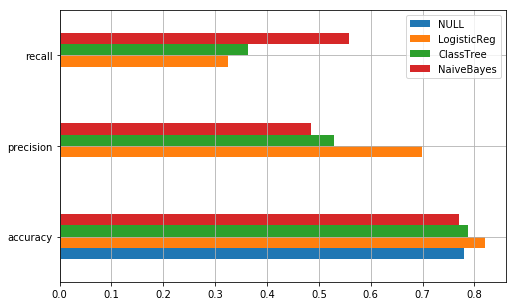

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [13]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test,
                                                               probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test,
                                                               probas_pred=logistic_regression.predict_proba(X_test)[:,1])

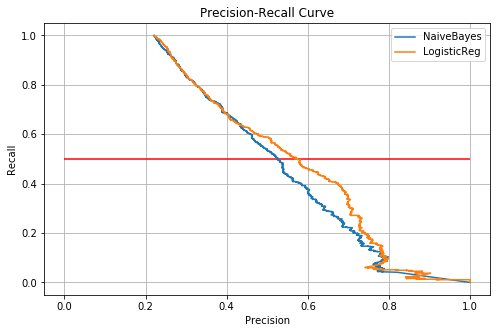

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

# Confusion Matrix - LogRegClass

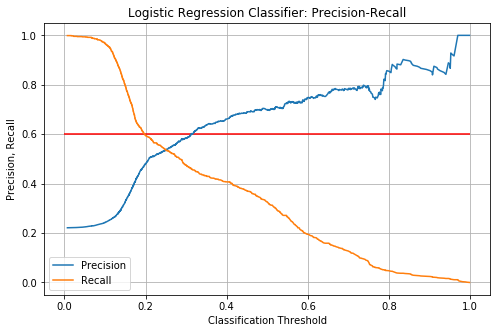

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

# Threshold 0.2

In [16]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall:", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision:", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CM

Recall: 59.497487437185924
Precision: 47.896440129449836


array([[2861,  644],
       [ 403,  592]])

# Individual Predictions

In [17]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [18]:
pay = default[default['default.payment.next.month']==0]

In [19]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 4000),('age', 50),('bill_amt1', 500),
                            ('bill_amt2', 35509),('bill_amt3', 689),('bill_am4', 0),
                            ('bill_amt5', 0),('bill_amt6', 0),('pay_amt1', 0),('pay_amt2', 0),
                            ('pay_amt3', 0),('pay_amt4', 0),('pay_amt5', 0), ('pay_amt6', 0),
                            ('male', 1),('grad_school', 0),('university', 1), ('high_school', 0),
                            ('married', 1),('pay_0', -1),('pay_2', -1),('pay_3', -1),
                            ('pay_4', 0),('pay_5', -1), ('pay_6', 0)])


new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default'